# Chapter 13

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings

In [2]:
plt.rcParams["figure.figsize"] = [14, 7] 

<Axes: title={'center': 'Monthly Energy Consumption'}, xlabel='Month'>

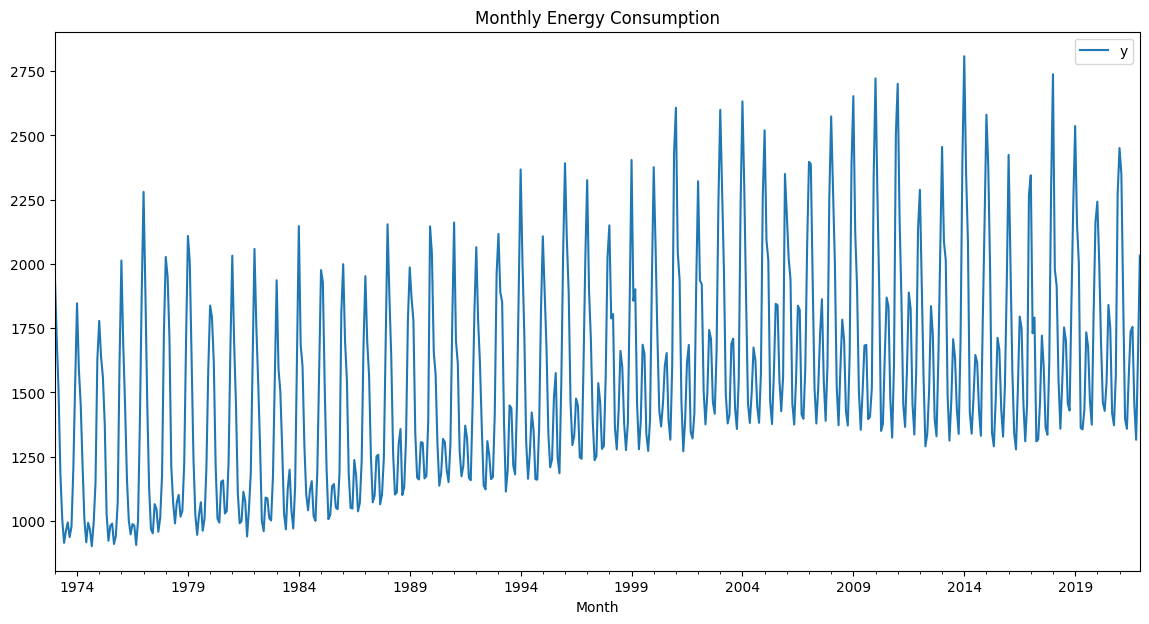

In [3]:
warnings.filterwarnings('ignore')
path = Path('../../datasets/Ch13/')
energy = pd.read_csv(path.joinpath('energy_consumption.csv'), 
                     index_col='Month', 
                     parse_dates=True)

energy.columns = ['y']
energy.index.freq = 'MS'
energy.plot(title='Monthly Energy Consumption')


In [4]:
en_cp = energy.copy()
def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)

def sequence_data_preparation(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()


def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test


class Standardize:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]


In [5]:
sequence_data_preparation(energy, 3)

,x1,x2,x3,y
Month,,,,
1973-01-01,1957.641,1712.143,1510.079,1183.421
1973-02-01,1712.143,1510.079,1183.421,1006.326
1973-03-01,1510.079,1183.421,1006.326,914.949
1973-04-01,1183.421,1006.326,914.949,961.872
1973-05-01,1006.326,914.949,961.872,994.259
...,...,...,...,...
2021-05-01,1358.566,1564.205,1737.442,1755.212
2021-06-01,1564.205,1737.442,1755.212,1456.901
2021-07-01,1737.442,1755.212,1456.901,1315.799


In [6]:
def features_target_ts(*args):
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x

In [7]:
en_df = sequence_data_preparation(en_cp, 10)

print(en_df.shape)

scale_en = Standardize(en_df)
train_en, test_en, val_en = scale_en.fit_transform()

print(f'''
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')

(578, 11)

energy: train: 469 , test: 57, val: 52



In [8]:
(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target_ts(train_en, 
                             val_en, 
                             test_en)

## Using LSTM (Keras)

In [9]:
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.layers import (BatchNormalization, Dense,  
                TimeDistributed, Bidirectional, 
                SimpleRNN, GRU, LSTM, Dropout)

def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,
                   input_shape=(train.shape[1], 
                                train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    return model
    
def train_model_ts(model, 
                x_train, y_train, x_val, y_val, 
                epochs=500, 
                patience=12, 
                batch_size=32):
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError(), 
                           MeanAbsoluteError()])
    es = keras.callbacks.EarlyStopping(
                    monitor="val_loss", 
                    min_delta=0, 
                    patience=patience)
    history = model.fit(x_train,y_train, 
              shuffle=False, epochs=epochs,
              batch_size=batch_size, 
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history
    
def plot_forecast(model, x_test, y_test, index, history):
    fig, ax = plt.subplots(2, 1)
    (pd.Series(history.history['loss'])
                      .plot(style='k',alpha=0.50, title='Loss by Epoch',
                            ax = ax[0], label='loss'))
    (pd.Series(history.history['val_loss'])
                      .plot(style='k',ax=ax[0],label='val_loss'))
    ax[0].legend()
    predicted = model.predict(x_test)
    predicted = scale_en.inverse_y(predicted)
    x_test = scale_en.inverse_y(x_test)
    y_test = scale_en.inverse_y(y_test)
    pd.Series(y_test.reshape(-1), 
              index=index).plot(style='k--', alpha=0.5, ax=ax[1], 
                                title='Forecast vs Actual',
                                label='actual')
    pd.Series(predicted.reshape(-1), 
              index=index).plot(
            style='k',label='Forecast', ax=ax[1])
    fig.tight_layout()
    ax[1].legend();plt.show()

In [10]:
model_en_lstm = create_model(train=x_train_en, units=32)
model_en_lstm.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,385 (17.13 KB)

 Trainable params: 4,385 (17.13 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history_en_lstm = train_model_ts(model_en_lstm, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

Epoch 1/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.9518 - mean_absolute_error: 0.8482 - root_mean_squared_error: 0.9747 - val_loss: 1.2846 - val_mean_absolute_error: 0.8396 - val_root_mean_squared_error: 1.1334
Epoch 2/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.9147 - mean_absolute_error: 0.8306 - root_mean_squared_error: 0.9556 - val_loss: 1.2548 - val_mean_absolute_error: 0.8339 - val_root_mean_squared_error: 1.1202
Epoch 3/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8799 - mean_absolute_error: 0.8141 - root_mean_squared_error: 0.9374 - val_loss: 1.2239 - val_mean_absolute_error: 0.8286 - val_root_mean_squared_error: 1.1063
Epoch 4/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8544 - mean_absolute_error: 0.8014 - root_mean_squared_error: 0.9238 - val_loss: 1.1955 - val_mean_absolute_error: 0.8232 - val_root_mean_squared_error: 1.0934
Epoch 5/500
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8313 - mean_absolute_error: 0.7875 - root_mean_squared_error: 0.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


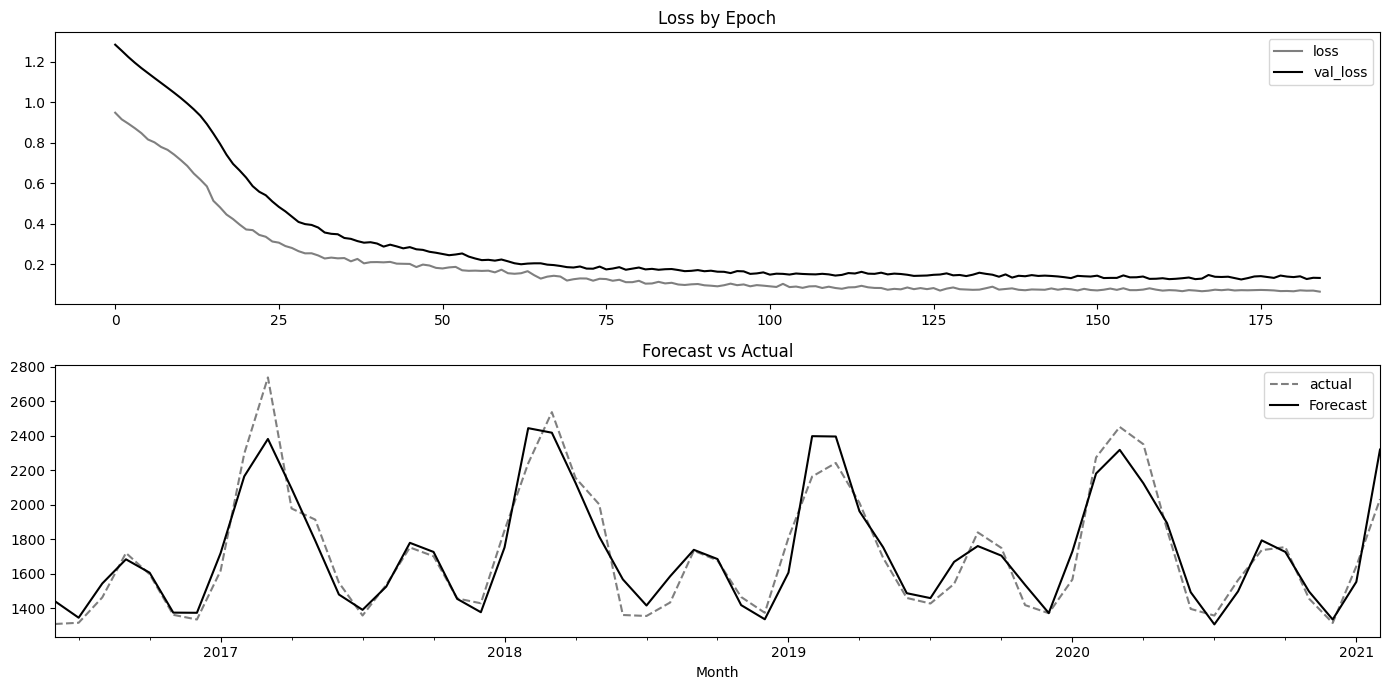

In [12]:
plot_forecast(model_en_lstm, x_test_en, y_test_en, test_en.index, history_en_lstm)

## Using LSTM (PyTorch)

In [13]:
# PyTorch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [14]:
def features_target_pt(*args):
    y = [torch.from_numpy(col.pop('y').values.reshape(-1,1)).float() for col in args]
    x = [torch.from_numpy(col.values.reshape(*col.shape, 1)).float()
                   for col in args]
    return *y, *x

In [15]:
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden

In [16]:
def train_model_pt(model_type='RNN', **kwargs):
    """
    Parameters:
        input_size: input size
        output_size: output size
        n_features: number of features (hidden dimension)
        n_layers: number of layers
        train_data: tuple ex (x_train, y_train)
        val_data: tuple ex (x_val, y_val)
        epochs: number of epochs
        print_every: output and history tracking
        lr: learning rate
    """
    if model_type=='RNN':
        model = RNN(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='LSTM':
        model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
    elif model_type=='GRU':
         model = LSTM(kwargs['input_size'], 
                    kwargs['output_size'], 
                    kwargs['units'], 
                    kwargs['n_layers'])
        
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=kwargs['lr'])
    
    x_train, y_train = kwargs['train_data']
    x_val, y_val  = kwargs['val_data']
    x_test, y_test = kwargs['test_data']
    
    history = {'loss': [], 'val_loss': []}
    # batch_size = x_train.shape[0]
    model.train()
    epochs = kwargs['epochs']
    print_every = kwargs['print_every']
    
    for batch_i, epoch in enumerate(range(epochs)):
        h = model.init_hidden()
        optimizer.zero_grad()
        pred, h = model(x_train, h) #model(x_train)
        #hidden = hidden.data
        loss = criterion(pred, y_train)        
        loss.backward()
        optimizer.step()
        if batch_i % print_every == 0:
            model.eval()
            with torch.no_grad():
                val_h = model.init_hidden()
                val_p, val_h = model(x_val, val_h)
                val_loss = criterion(val_p, y_val)
                history['val_loss'].append(val_loss.item())
            model.train()
            history['loss'].append(loss.item())
            print(f'{batch_i}/{epochs} - Loss:  {loss.item()}, val_loss: {val_loss.item()}')
    
    ## Prediction
    model.eval()
    with torch.no_grad():
        h0 = model.init_hidden()
        y_hat = model(x_test, h0)
    y_hat, _ = y_hat
    mse_loss_air = criterion(y_hat, y_test)
    print(f'Test MSE Loss: {mse_loss_air.item():.4f}')
    
    ## Plotting
    fig, ax = plt.subplots(2, 1) 

    ax[0].set_title(f'{model_type}: Loss and Validation Loss per epoch')
    ax[0].plot(history['loss'], 'k--', label='loss')
    ax[0].plot(history['val_loss'], 'k', label='val_loss')
    ax[0].legend()
    ax[1].set_title(f"{model_type} TEST MSE = {mse_loss_air.item():.4f}: Forecast vs Actual (Out-of-Sample data)")
    scale = kwargs['scale']
    actual = scale.inverse_y(y_test.detach().numpy().ravel())
    pred = scale.inverse_y(y_hat.detach().numpy().ravel())
    idx = kwargs['idx']
    pd.Series(actual, index=idx).plot(style='k--', label='actual', alpha=0.65)
    pd.Series(pred, index=idx).plot(style='k', label='forecast')
    fig.tight_layout()
    ax[1].legend(); plt.show()
    
    return model, history

In [17]:
train_en, test_en, val_en = scale_en.fit_transform()

(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target_pt(train_en, 
                             val_en, 
                             test_en)

0/500 - Loss:  0.9879710078239441, val_loss: 1.1201306581497192
20/500 - Loss:  0.12525536119937897, val_loss: 0.23800328373908997
40/500 - Loss:  0.07574848085641861, val_loss: 0.17120963335037231
60/500 - Loss:  0.0719527080655098, val_loss: 0.15162886679172516
80/500 - Loss:  0.05901841074228287, val_loss: 0.14437758922576904
100/500 - Loss:  0.05684557929635048, val_loss: 0.14470241963863373
120/500 - Loss:  0.054797738790512085, val_loss: 0.1399509310722351
140/500 - Loss:  0.049321249127388, val_loss: 0.13550302386283875
160/500 - Loss:  0.048383928835392, val_loss: 0.13397233188152313
180/500 - Loss:  0.04256953299045563, val_loss: 0.12759745121002197
200/500 - Loss:  0.04230732470750809, val_loss: 0.1270136535167694
220/500 - Loss:  0.03796017915010452, val_loss: 0.1275971531867981
240/500 - Loss:  0.0358988456428051, val_loss: 0.1404201090335846
260/500 - Loss:  0.03378524258732796, val_loss: 0.13951565325260162
280/500 - Loss:  0.032474249601364136, val_loss: 0.13874313235282

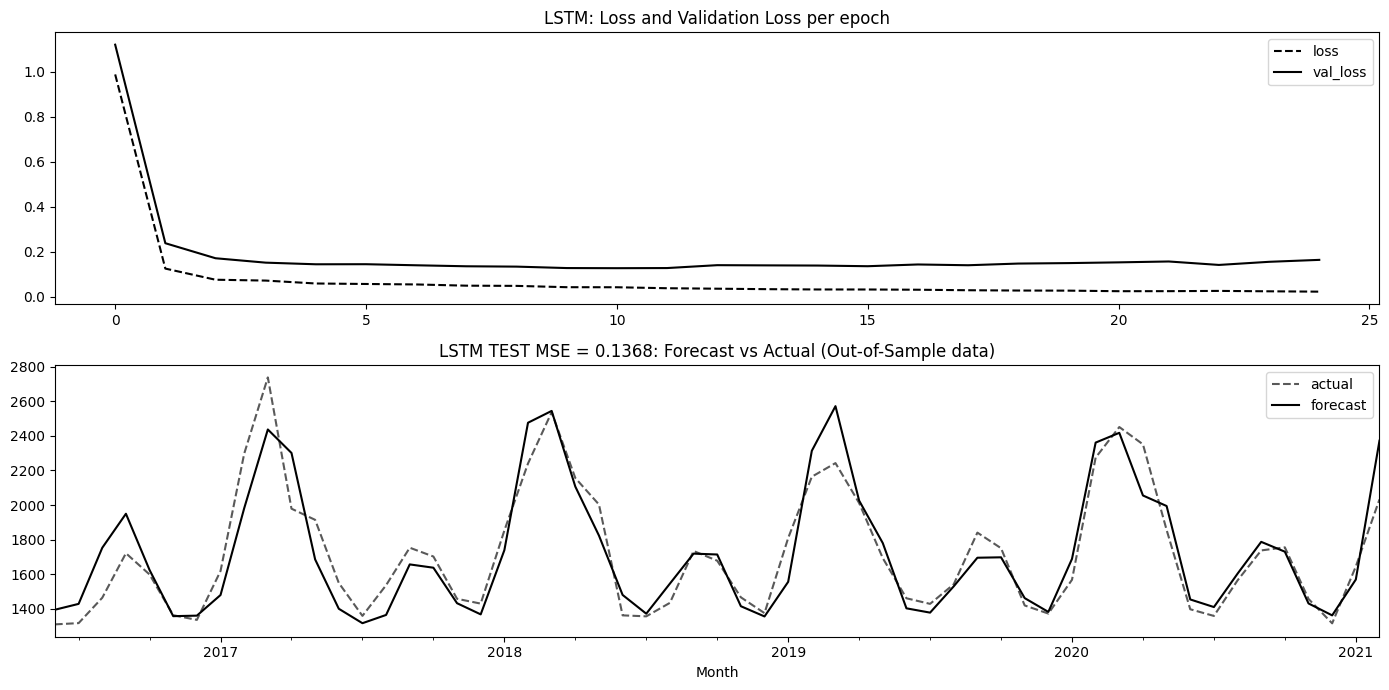

In [18]:
params_en = {'input_size':x_train_en.shape[1],
'output_size':1,
'units':32,
'n_layers':1,
'epochs': 500,
'print_every': 20,
'lr': 0.01,
'train_data': (x_train_en, y_train_en),
'val_data': (x_val_en, y_val_en),
'test_data': (x_test_en, y_test_en),
'idx': test_en.index,
'scale': scale_en}



en_lstm, history_en_lstm = train_model_pt('LSTM', **params_en)

In [19]:
# LSTM wiht dropout
class LSTM(nn.Module):
    def __init__(self, input_size, output_size, n_features, n_layers):
        super(LSTM, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = n_features
        self.lstm = nn.LSTM(input_size, n_features, n_layers, batch_first=True, dropout=0.70)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(n_features, output_size)
        
    def forward(self, x, hn):
        # batch_first=True -> (batch_size, seq_length, input_size)
        x = x.view(1, x.shape[0], x.shape[1])
        lstm_o, hn = self.lstm(x, hn)
        lstm_o = self.dropout(lstm_o)
        # reshape
        lstm_o = lstm_o.view(-1, self.hidden_dim)
        output = self.fc(lstm_o)
        return output, hn

    def init_hidden(self):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, 1, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, 1, self.hidden_dim).zero_())
        return hidden


0/500 - Loss:  1.0251195430755615, val_loss: 1.3432049751281738
20/500 - Loss:  0.13428713381290436, val_loss: 0.2859210669994354
40/500 - Loss:  0.08448616415262222, val_loss: 0.21008943021297455
60/500 - Loss:  0.06552430987358093, val_loss: 0.18958909809589386
80/500 - Loss:  0.06378293037414551, val_loss: 0.17509037256240845
100/500 - Loss:  0.05318662151694298, val_loss: 0.1634512096643448
120/500 - Loss:  0.05161190405488014, val_loss: 0.15995655953884125
140/500 - Loss:  0.05396902561187744, val_loss: 0.16397593915462494
160/500 - Loss:  0.0445946604013443, val_loss: 0.1713901311159134
180/500 - Loss:  0.044140733778476715, val_loss: 0.15255524218082428
200/500 - Loss:  0.041285641491413116, val_loss: 0.1484968066215515
220/500 - Loss:  0.04322762042284012, val_loss: 0.1555197834968567
240/500 - Loss:  0.04237697273492813, val_loss: 0.15122677385807037
260/500 - Loss:  0.034267768263816833, val_loss: 0.1471368968486786
280/500 - Loss:  0.03815536946058273, val_loss: 0.1505931764

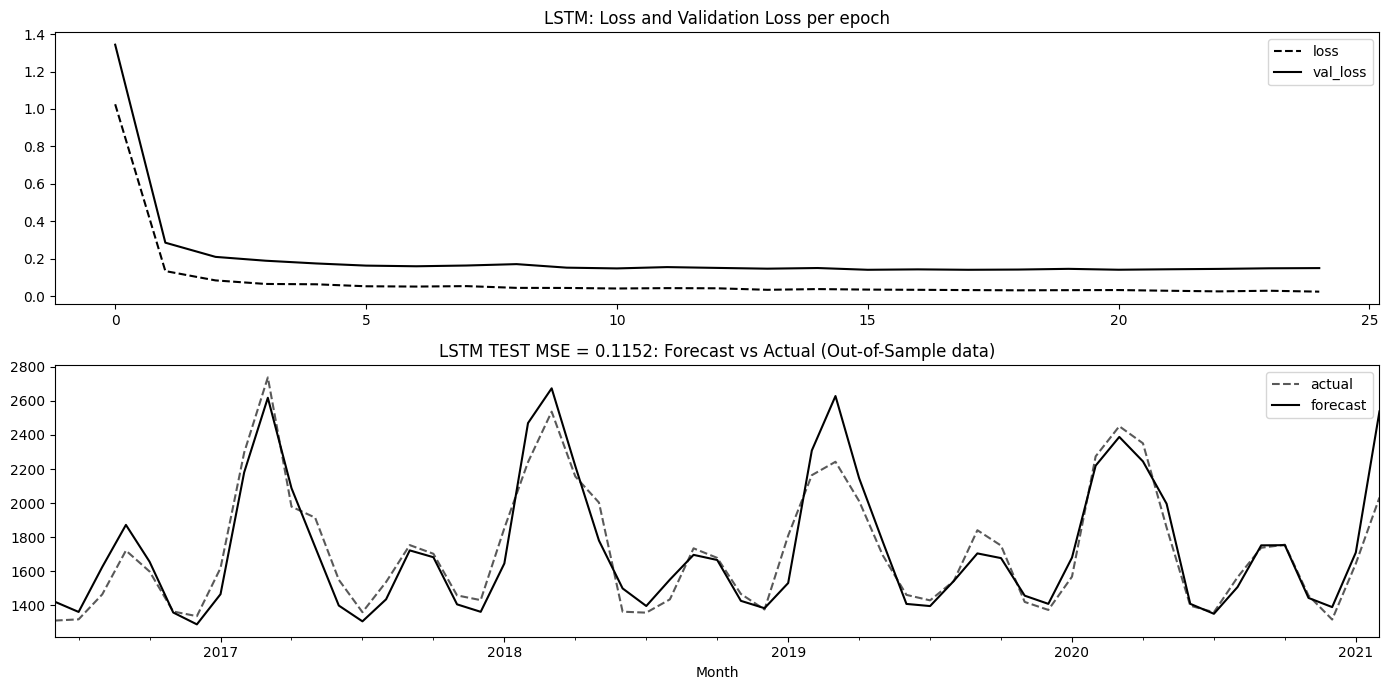

In [20]:
en_lstm_d, history_en_lstm_d = train_model_pt('LSTM', **params_en)

## Darts LSTM

In [33]:
# Issue where darts and u8darts were not same version. Just upgrade to ensure they are the same vesrion
#!pip install -U u8darts -q

In [41]:
!conda list dart

# packages in environment at /opt/anaconda3/envs/deep:
#
# Name                    Version                   Build  Channel
darts                     0.35.0                   pypi_0    pypi
u8darts                   0.35.0                   pypi_0    pypi


In [21]:
import darts
darts.__version__

'0.35.0'

In [22]:
from darts.models import RNNModel
from darts import TimeSeries

In [23]:
en_cp.reset_index()

,Month,y
0,1973-01-01,1957.641
1,1973-02-01,1712.143
2,1973-03-01,1510.079
3,1973-04-01,1183.421
4,1973-05-01,1006.326
...,...,...
583,2021-08-01,1755.212
584,2021-09-01,1456.901
585,2021-10-01,1315.799
586,2021-11-01,1644.306


In [27]:
# limitations for MacBook M1
en_cp['y'] = en_cp['y'].astype('float32')
ts = TimeSeries.from_dataframe(en_cp.reset_index(), 
                               time_col='Month', 
                               value_cols='y', 
                               freq='MS')

val_split_point = int(len(ts) * 0.85) # Use first 85% for training
train, val = ts[:val_split_point], ts[val_split_point:]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit scaler ONLY on training data and transform both
# train_scaled = scaler.fit_transform(train)
# val_scaled = scaler.transform(val)
# series_scaled = scaler.transform(ts)

In [58]:
#train, val = ts.split_before(0.8)

In [28]:
INPUT_CHUNK_LENGTH = 10 # How many time steps the model sees (your 'window')
OUTPUT_CHUNK_LENGTH = 1  # How many steps the model predicts forward at a time
N_EPOCHS = 500           # Max number of epochs
HIDDEN_DIM = 32          # LSTM units
N_RNN_LAYERS = 1         # Number of LSTM layers
DROPOUT = 0.2            # Dropout rate
BATCH_SIZE = 32          # Batch size for training

model = RNNModel(
    model='LSTM',               # Specify the RNN type
    input_chunk_length=INPUT_CHUNK_LENGTH,
    output_chunk_length=OUTPUT_CHUNK_LENGTH,
    hidden_dim=HIDDEN_DIM,     # Note: darts uses hidden_size
    n_rnn_layers=N_RNN_LAYERS,
    dropout=DROPOUT,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    optimizer_kwargs={'lr': 1e-3}, # Adam is default, set learning rate
    model_name='energy_lstm',
    log_tensorboard=False,       # Set True to use TensorBoard
    random_state=42,            # For reproducibility
    force_reset=True,           # Ensure fresh model training
    save_checkpoints=False,      # Set True to save model checkpoints
)

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.


In [ ]:
model.fit(train, val_series=val, verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 0: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:02<00:00,  5.81it/s, train_loss=2.25e+6]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 121.65it/s, train_loss=2.42e+6, val_loss=3.09e+6]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|██████████████████████████████

In [32]:
forecast = model.predict(len(val))
#forecast = scaler.inverse_transform(forecast)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 36.57it/s]


In [33]:
from darts.metrics import mape

error = mape(val, forecast)
print(f"MAPE: {error:.2f}%")

MAPE: 97.12%


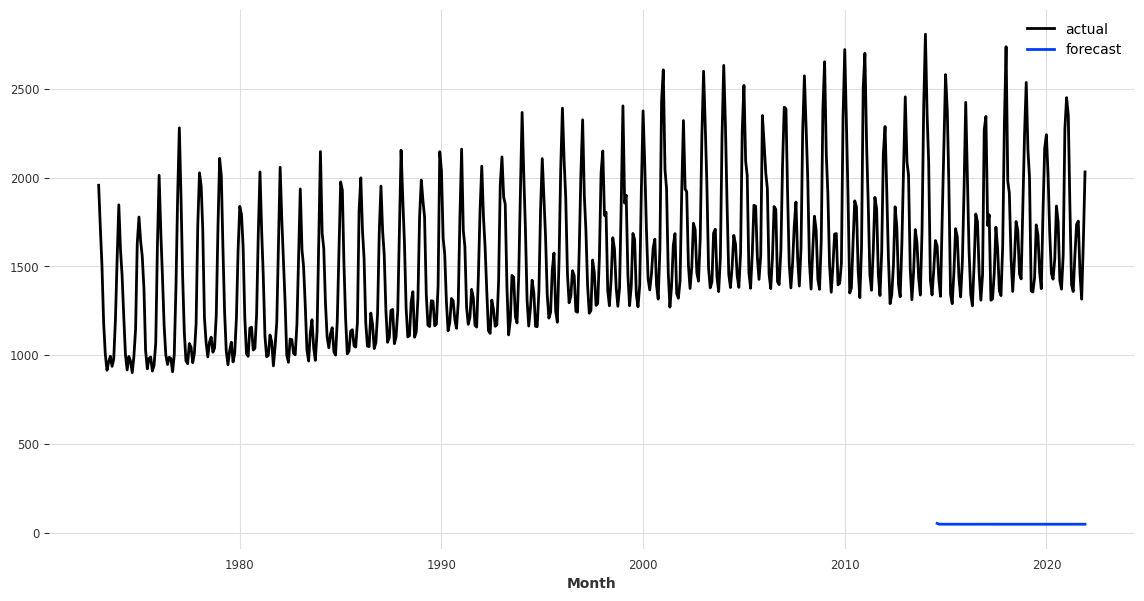

In [34]:
import matplotlib.pyplot as plt

ts.plot(label='actual')
forecast.plot(label='forecast')
plt.legend()
plt.show()

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 4.5 K  | train
6 | V               | Linear           | 33     | train
-------------------------------------------------------------
4.5 K     Trainable params
0         Non-trainable params
4.5 K     Total params
0.018     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Starting model training...
Epoch 0: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 108.51it/s, train_loss=0.851]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 95.43it/s, train_loss=0.851, val_loss=0.981]

Metric val_loss improved. New best score: 0.981


Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 134.00it/s, train_loss=0.898, val_loss=0.981]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 1: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 115.40it/s, train_loss=0.898, val_loss=0.947]

Metric val_loss improved by 0.034 >= min_delta = 0.001. New best score: 0.947


Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 132.99it/s, train_loss=0.769, val_loss=0.947]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 2: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 118.03it/s, train_loss=0.769, val_loss=0.881]

Metric val_loss improved by 0.066 >= min_delta = 0.001. New best score: 0.881


Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 130.29it/s, train_loss=0.709, val_loss=0.881]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 3: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 114.43it/s, train_loss=0.709, val_loss=0.793]

Metric val_loss improved by 0.089 >= min_delta = 0.001. New best score: 0.793


Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 128.93it/s, train_loss=0.696, val_loss=0.793]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 4: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 112.94it/s, train_loss=0.696, val_loss=0.739]

Metric val_loss improved by 0.053 >= min_delta = 0.001. New best score: 0.739


Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 128.75it/s, train_loss=0.543, val_loss=0.739]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 5: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 112.94it/s, train_loss=0.543, val_loss=0.655]

Metric val_loss improved by 0.084 >= min_delta = 0.001. New best score: 0.655


Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 127.13it/s, train_loss=0.519, val_loss=0.655]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 6: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 112.55it/s, train_loss=0.519, val_loss=0.572]

Metric val_loss improved by 0.083 >= min_delta = 0.001. New best score: 0.572


Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 127.72it/s, train_loss=0.334, val_loss=0.572]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 7: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 112.14it/s, train_loss=0.334, val_loss=0.508]

Metric val_loss improved by 0.064 >= min_delta = 0.001. New best score: 0.508


Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 124.60it/s, train_loss=0.322, val_loss=0.508]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 8: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 109.76it/s, train_loss=0.322, val_loss=0.453]

Metric val_loss improved by 0.054 >= min_delta = 0.001. New best score: 0.453


Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 127.82it/s, train_loss=0.327, val_loss=0.453]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 9: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 112.52it/s, train_loss=0.327, val_loss=0.411]

Metric val_loss improved by 0.042 >= min_delta = 0.001. New best score: 0.411


Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 127.66it/s, train_loss=0.302, val_loss=0.411]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 10: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 113.65it/s, train_loss=0.302, val_loss=0.372]

Metric val_loss improved by 0.039 >= min_delta = 0.001. New best score: 0.372


Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 130.92it/s, train_loss=0.212, val_loss=0.372]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 11: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 115.40it/s, train_loss=0.212, val_loss=0.338]

Metric val_loss improved by 0.034 >= min_delta = 0.001. New best score: 0.338


Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 124.73it/s, train_loss=0.216, val_loss=0.338]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 12: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 109.74it/s, train_loss=0.216, val_loss=0.306]

Metric val_loss improved by 0.032 >= min_delta = 0.001. New best score: 0.306


Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 135.08it/s, train_loss=0.186, val_loss=0.306]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 13: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 119.38it/s, train_loss=0.186, val_loss=0.274]

Metric val_loss improved by 0.033 >= min_delta = 0.001. New best score: 0.274


Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 135.68it/s, train_loss=0.151, val_loss=0.274]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 14: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 118.81it/s, train_loss=0.151, val_loss=0.244]

Metric val_loss improved by 0.030 >= min_delta = 0.001. New best score: 0.244


Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 132.67it/s, train_loss=0.170, val_loss=0.244]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 15: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 117.70it/s, train_loss=0.170, val_loss=0.222]

Metric val_loss improved by 0.022 >= min_delta = 0.001. New best score: 0.222


Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 128.92it/s, train_loss=0.139, val_loss=0.222]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 16: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 113.15it/s, train_loss=0.139, val_loss=0.210]

Metric val_loss improved by 0.012 >= min_delta = 0.001. New best score: 0.210


Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 125.43it/s, train_loss=0.126, val_loss=0.210]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 17: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 110.63it/s, train_loss=0.126, val_loss=0.199]

Metric val_loss improved by 0.011 >= min_delta = 0.001. New best score: 0.199


Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 126.01it/s, train_loss=0.121, val_loss=0.199]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 18: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 111.22it/s, train_loss=0.121, val_loss=0.192]

Metric val_loss improved by 0.007 >= min_delta = 0.001. New best score: 0.192


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 75.22it/s, train_loss=0.126, val_loss=0.192]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 65.55it/s, train_loss=0.126, val_loss=0.185]

Metric val_loss improved by 0.006 >= min_delta = 0.001. New best score: 0.185


Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 124.24it/s, train_loss=0.108, val_loss=0.185]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 20: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 109.03it/s, train_loss=0.108, val_loss=0.182]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.182


Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 128.02it/s, train_loss=0.105, val_loss=0.182]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 21: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 112.30it/s, train_loss=0.105, val_loss=0.179]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.179


Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 128.57it/s, train_loss=0.0974, val_loss=0.179]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 22: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 112.83it/s, train_loss=0.0974, val_loss=0.177]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.177


Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 126.04it/s, train_loss=0.124, val_loss=0.177]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 23: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 109.75it/s, train_loss=0.124, val_loss=0.174]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.174


Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 126.58it/s, train_loss=0.105, val_loss=0.174]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 24: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 111.01it/s, train_loss=0.105, val_loss=0.173]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.173


Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 136.02it/s, train_loss=0.115, val_loss=0.173]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 25: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 121.87it/s, train_loss=0.115, val_loss=0.170]

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.170


Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 140.16it/s, train_loss=0.113, val_loss=0.170]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 26: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 123.55it/s, train_loss=0.113, val_loss=0.168]

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.168


Epoch 27: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 136.75it/s, train_loss=0.097, val_loss=0.168]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 137.14it/s, train_loss=0.105, val_loss=0.167]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 28: 100%|█████████████████████████████

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.166


Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 139.06it/s, train_loss=0.098, val_loss=0.166]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 29: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 123.65it/s, train_loss=0.098, val_loss=0.165]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.165


Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 134.86it/s, train_loss=0.0862, val_loss=0.165]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 30: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 118.85it/s, train_loss=0.0862, val_loss=0.164]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.164


Epoch 31: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 134.01it/s, train_loss=0.0966, val_loss=0.164]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 32: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 133.73it/s, train_loss=0.0976, val_loss=0.164]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 32: 100%|█████████████████████████████

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.161


Epoch 33: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 136.37it/s, train_loss=0.0939, val_loss=0.161]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 34: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 135.83it/s, train_loss=0.0983, val_loss=0.160]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 35: 100%|█████████████████████████████

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.159


Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 139.70it/s, train_loss=0.105, val_loss=0.159]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 36: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 124.47it/s, train_loss=0.105, val_loss=0.158]

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.158


Epoch 37: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 140.79it/s, train_loss=0.0847, val_loss=0.158]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 38: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 140.77it/s, train_loss=0.0954, val_loss=0.158]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 39: 100%|█████████████████████████████

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.157


Epoch 40: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 138.45it/s, train_loss=0.0931, val_loss=0.157]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 41: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 131.79it/s, train_loss=0.0913, val_loss=0.156]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 41: 100%|█████████████████████████████

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.155


Epoch 42: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 137.54it/s, train_loss=0.0823, val_loss=0.155]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 43: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 140.67it/s, train_loss=0.0744, val_loss=0.155]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 44: 100%|█████████████████████████████

Metric val_loss improved by 0.002 >= min_delta = 0.001. New best score: 0.153


Epoch 46: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 140.77it/s, train_loss=0.0865, val_loss=0.153]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 47: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 141.52it/s, train_loss=0.0827, val_loss=0.152]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 48: 100%|█████████████████████████████

Metric val_loss improved by 0.003 >= min_delta = 0.001. New best score: 0.150


Epoch 51: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 138.30it/s, train_loss=0.0788, val_loss=0.150]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 52: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 135.66it/s, train_loss=0.0778, val_loss=0.151]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 53: 100%|█████████████████████████████

Metric val_loss improved by 0.001 >= min_delta = 0.001. New best score: 0.149


Epoch 57: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 139.17it/s, train_loss=0.0766, val_loss=0.149]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 58: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 137.34it/s, train_loss=0.0784, val_loss=0.150]
Validation: |                                                                                                                                                                                                           | 0/? [00:00<?, ?it/s]
Epoch 59: 100%|█████████████████████████████

Monitored metric val_loss did not improve in the last 12 records. Best score: 0.149. Signaling Trainer to stop.


Epoch 68: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 122.56it/s, train_loss=0.0827, val_loss=0.149]
Generating predictions...


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting DataLoader 0: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 45.47it/s]


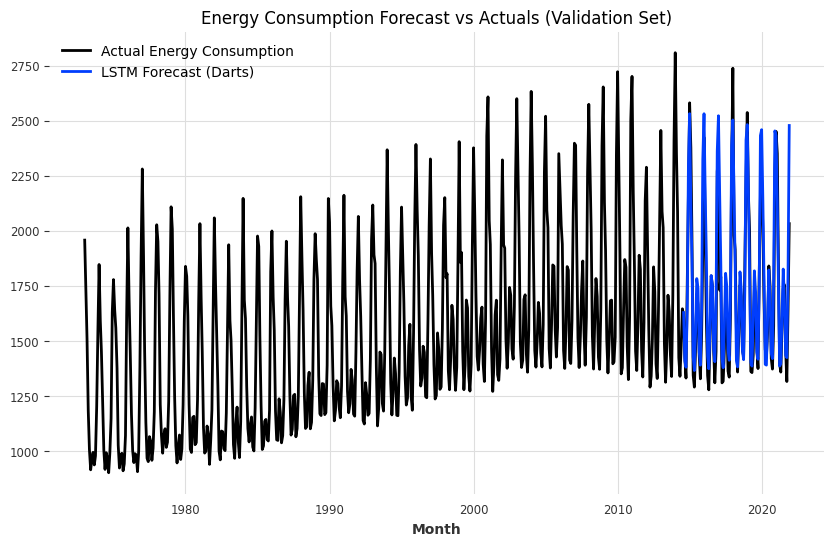

Validation RMSE: 135.8204
Validation MAE:  101.6598


In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import warnings

# Darts specific imports
from darts import TimeSeries
from darts.models import RNNModel  # Using RNNModel with model='LSTM'
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.metrics import rmse, mae

# PyTorch Lightning for trainer control (optional but common)
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

warnings.filterwarnings('ignore')

# --- 1. Data Loading and Initial Preparation ---
path = Path('../../datasets/Ch13/')
energy_df = energy.copy()
# Handle missing data (if any) - Same as before
n_missing = int(energy_df.isna().sum().sum())
if n_missing > 0:
    print(f'Found {n_missing} missing observations... filling forward.')
    energy_df.ffill(inplace=True)

# Convert Pandas Series/DataFrame to Darts TimeSeries
# Darts works best if the series has a unique name
series = TimeSeries.from_series(energy_df['y'], freq='MS')

# --- 2. Splitting Data ---
# Define split point (e.g., last 15% for validation/test)
# Let's do Train / Validation split first for model training
val_split_point = int(len(series) * 0.85) # Use first 85% for training
train, val = series[:val_split_point], series[val_split_point:]

# (Optional: Further split val into val and test if needed for final evaluation)
# test_split_point = int(len(val) * 0.5)
# val, test = val[:test_split_point], val[test_split_point:]


# --- 3. Scaling ---
# Use Darts Scaler (defaults to MinMaxScaler, use StandardScaler for consistency)
# You can choose different scalers from sklearn via darts wrapper
from sklearn.preprocessing import StandardScaler
scaler = Scaler(StandardScaler())

# Fit scaler ONLY on training data and transform both
train_scaled = scaler.fit_transform(train)
val_scaled = scaler.transform(val)
series_scaled = scaler.transform(series) # Scale the whole series if needed later

# --- 4. Define and Train the Darts RNNModel (LSTM) ---

# Define parameters matching your previous setup where possible
INPUT_CHUNK_LENGTH = 10 # How many time steps the model sees (your 'window')
OUTPUT_CHUNK_LENGTH = 1  # How many steps the model predicts forward at a time
N_EPOCHS = 500           # Max number of epochs
HIDDEN_DIM = 32          # LSTM units
N_RNN_LAYERS = 1         # Number of LSTM layers
DROPOUT = 0.2            # Dropout rate
BATCH_SIZE = 32          # Batch size for training
PATIENCE = 12            # Early stopping patience

# Define PyTorch Lightning callbacks (e.g., Early Stopping)
# The logs_key='val_loss' assumes the validation loss is logged with this key
# Darts models using PyTorch Lightning often log validation loss automatically
early_stopper = EarlyStopping(
    monitor="val_loss",  # Darts/PyTorch Lightning default validation loss metric name
    patience=PATIENCE,
    min_delta=0.001,     # Minimum change to qualify as an improvement
    mode='min',          # We want to minimize loss
    verbose=True
)

# Add callbacks to pl_trainer_kwargs
# You can add other Pytorch Lightning Trainer args here (e.g., accelerator='gpu')
trainer_kwargs = {
    "callbacks": [early_stopper],
    "enable_progress_bar": True # Show training progress bar
    # Add "accelerator": "gpu", "devices": 1 if using GPU
}

# Create the RNNModel instance - specify 'LSTM'
# Make sure torch is installed: pip install torch
# Make sure pytorch-lightning is installed: pip install pytorch-lightning
model_en_lstm_darts = RNNModel(
    model='LSTM',               # Specify the RNN type
    input_chunk_length=INPUT_CHUNK_LENGTH,
    output_chunk_length=OUTPUT_CHUNK_LENGTH,
    hidden_dim=HIDDEN_DIM,     # Note: darts uses hidden_size
    n_rnn_layers=N_RNN_LAYERS,
    dropout=DROPOUT,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    optimizer_kwargs={'lr': 1e-3}, # Adam is default, set learning rate
    model_name='energy_lstm',
    log_tensorboard=False,       # Set True to use TensorBoard
    random_state=42,            # For reproducibility
    force_reset=True,           # Ensure fresh model training
    save_checkpoints=False,      # Set True to save model checkpoints
    pl_trainer_kwargs=trainer_kwargs # Pass trainer args including callbacks
)

print("Starting model training...")
# Train the model using the scaled training data
# Provide val_scaled for validation loss calculation and early stopping
model_en_lstm_darts.fit(train_scaled,
                        val_series=val_scaled,
                        verbose=True) # verbose=True shows epoch progress

# --- 5. Forecasting ---
print("Generating predictions...")
# Predict on the validation set timeframe
# n = number of steps to predict (length of validation set)
# The model automatically uses the end of the training series as input
preds_scaled = model_en_lstm_darts.predict(n=len(val))

# Inverse transform the predictions to the original scale
preds_energy = scaler.inverse_transform(preds_scaled)

# --- 6. Plotting and Evaluation ---
plt.figure(figsize=(10, 6))
series.plot(label='Actual Energy Consumption') # Plot full historical data
preds_energy.plot(label='LSTM Forecast (Darts)')
plt.title('Energy Consumption Forecast vs Actuals (Validation Set)')
plt.legend()
plt.show()

# Evaluate the forecast (on the validation set)
rmse_val = rmse(val, preds_energy)
mae_val = mae(val, preds_energy)
print(f"Validation RMSE: {rmse_val:.4f}")
print(f"Validation MAE:  {mae_val:.4f}")

# (Optional) You could retrain on train+val and predict on a final test set
# test_scaled = scaler.transform(test)
# model.fit(scaler.transform(train+val)) # Fit on combined data
# test_preds_scaled = model.predict(n=len(test))
# test_preds = scaler.inverse_transform(test_preds_scaled)
# rmse_test = rmse(test, test_preds) # Evaluate on test set

In [36]:
from darts.metrics import mape

error = mape(val, preds_energy)
print(f"MAPE: {error:.2f}%")

MAPE: 5.77%
